In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

## Beolvasás

* szűrés OK = 1-re
* üres név és nem szükséges rekordok kiszűrése
* contractstartyear  -> True-False
* datatype-ok beállítása

In [2]:
df = pd.read_excel("Excel_data.xlsx")

In [3]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [4]:
df = df.dropna(subset=['Name'])
index = df[df['OK'] < 1].index
df = df.drop(index).reset_index(drop=True)

In [5]:
delete = df[df.Notes == 'placed on IL (~CBC)'].index
df = df.drop(delete).reset_index(drop=True)

In [6]:
for row in range (len(df)):
    for column in range (11):
        newcontract = df.iloc[row,column+6]
        if newcontract != 0: 
            df.iloc[row,column+6] = 1

In [7]:
df = df.astype({"Team" : 'string',
                "Name" : 'string',
                "Notes" : 'string',
                "ContractStartYear_2010":'boolean',
                "ContractStartYear_2011":'boolean',
                "ContractStartYear_2012":'boolean',
                "ContractStartYear_2013":'boolean',
                "ContractStartYear_2014":'boolean',
                "ContractStartYear_2015":'boolean',
                "ContractStartYear_2016":'boolean',
                "ContractStartYear_2017":'boolean',
                "ContractStartYear_2018":'boolean',
                "ContractStartYear_2019":'boolean',
                "ContractStartYear_2020":'boolean', 
                'salary_2010':'float64',
                'salary_2011':'float64',
                'salary_2012':'float64',
                'salary_2013':'float64',
                'salary_2014':'float64',
                'salary_2015':'float64',
                'salary_2016':'float64',
                'salary_2017':'float64',
                'salary_2018':'float64',
                'salary_2019':'float64',
                'salary_2020':'float64',
                'POS_2010':'string'}) 

In [8]:
columns_to_check = ['POS_2010', 'POS_2011', 'POS_2012', 'POS_2013', 'POS_2014',
                   'POS_2015', 'POS_2016', 'POS_2017', 'POS_2018', 'POS_2019', 'POS_2020']
nan_counts = df[columns_to_check].isna().sum(axis=1)
df = df[nan_counts < 11]

In [9]:
index_to_delete=[]
for r in range(len(df)):
    true_count = 0
    for c in range(11):
        if df.iloc[r,6+c]:
            true_count+=1
    if true_count == 0:
        index_to_delete.append(r)

In [10]:
df = df.reset_index(drop=True)

In [11]:
df = df.drop(index_to_delete).reset_index(drop=True)

## Sérülések szótára

In [12]:
def check_body_part(text):
    body_parts = {'Achilles': 'Achilles','right knee': 'right knee', 'left knee': 'left knee', 'ACL': 'knee',
                  'foot': 'foot', 'shoulder': 'shoulder', 'hip': 'hip',
                  'toe': 'toe', 'lower back': 'lower back','thigh': 'thigh',
                  'adductor': 'thigh','left ankle': 'left ankle', 'right ankle': 'right ankle', 'waist': 'waist',
                  'wrist': 'wrist','arm':'arm','finger':'finger',
                  'calf':'calf','groin':'groin', 'shin':'shin','quadricep':'thigh',
                  'oblique muscle':'abdomen', 'abdomen':'abdomen', 'abdominal':'abdomen',
                  'elbow':'elbow', 'neck':'neck', 'thumb':'finger', 'back':'back',
                  'cuff':'shoulder','hamstring':'thigh','hand':'hand','fibula':'shin',
                  'core': 'abdomen','kene':'knee','oblique':'abdomen',
                  'gastrocnemius':'calf','tibia':'shin',
                  'pectoral muscle':'chest','chest':'chest','leg':'leg','bicep':'arm',
                  'triceps':'arm','glute':'glute','ankle':'ankle','knee':'knee','ligament':'ligament',
                  'ankles':'ankle','knees':'knee'}
    for key in body_parts:
        if str(key).lower() in text.lower():
            return body_parts[key]
    return 'TBD'

In [13]:
df['Body_part'] = df['Notes'].apply(check_body_part)

In [14]:
df.insert(loc=df.columns.get_loc('Notes') + 1, column='Body_part', value=df.pop('Body_part'))

## Azonosító létrehozása, duplikátumoktól mentes adattábla létrehozása

In [15]:
df['ID'] = df.apply(lambda x: x['Name'] + '-'+str(x['SeasonOfInjury']) +'-'+ x['Body_part'], axis=1)
df.insert(loc=df.columns.get_loc('Notes') + 1, column='Body_part', value=df.pop('Body_part'))
df.insert(loc=0, column='ID', value=df.pop('ID'))

In [16]:
droppeddf = df.drop_duplicates(subset=['ID'])
pd.set_option('display.max_colwidth',100)
droppeddf = droppeddf.reset_index(drop=True)

In [17]:
years = range(2010, 2021)
for year in years:
    droppeddf[f'2PA_{year}'] = droppeddf[f'2PA_{year}'] / droppeddf[f'GP_{year}']
    droppeddf[f'3PA_{year}'] = droppeddf[f'3PA_{year}'] / droppeddf[f'GP_{year}']

## Átlagok képzése a teljesítménymutatókból,fizetésekből

In [18]:
def calculate_averages(row):
    indexes = [19,41,52,63,74,85,96]
    listoflists = []
    for ind in indexes:
        averages = []
        current_sum = 0
        years_so_far = 0    
        for i in range(11):
            current_stat = row.iloc[0, i+ind]
            is_new_contract = (i == 10) or row.iloc[0, i+9]
            if not np.isnan(current_stat) and not np.isnan(row.iloc[0, i+41]):
                current_sum+=current_stat
                years_so_far+=1
            if is_new_contract and years_so_far != 0:
                avg = current_sum / years_so_far
                averages.append(avg)
                current_sum = 0
                years_so_far = 0
        listoflists.append(averages)          
                    
    return listoflists

In [19]:
results=[]
for i in range(len(droppeddf)):
    results.append(calculate_averages(droppeddf.iloc[i:i+1,:]))
droppeddf['results'] = results

In [20]:
mode_df = droppeddf.iloc[:, 30:41].mode(axis=1,dropna=True)
mode_series = mode_df.iloc[:, 0]
droppeddf['POS'] = mode_series

In [21]:
def check_POS(text):
    position = {'C-F': 'C','F': 'SF','F-C': 'PF','F-G': 'SG','G':'PG','G-F':'SF','35.2':'C'}
    for key in position:
        if key == text:
            return position[key]
    return text
droppeddf['POS'] = droppeddf['POS'].apply(check_POS)

In [22]:
posts = pd.get_dummies(droppeddf['POS'],drop_first=True)

In [23]:
def contractStartDates(row):
    dates=[]
    for col in range (row.shape[0]):
        if row[col]:
            dates.append(2010+col)
    return dates

In [24]:
data=droppeddf.iloc[:,8:19]
droppeddf['contractStartDates'] = data.apply(contractStartDates, axis=1)

## Sérülések kigyűjtése

In [25]:
column_names=['salary','age','MPG','2PA','3PA','RPG','SPG']
df2  = pd.DataFrame(results,columns=column_names)
df2['POS'] = droppeddf['POS']
df2['SeasonOfInjury'] = droppeddf['SeasonOfInjury']
df2['contractStartDates'] = droppeddf['contractStartDates']
df2['Name'] = droppeddf['Name']
df2.head()

,salary,age,MPG,2PA,3PA,RPG,SPG,POS,SeasonOfInjury,contractStartDates,Name
0,"[19020423.25, 20885969.0]","[30.5, 33.0]","[30.2, 23.8]","[13.584485621125037, 10.464788732394366]","[0.016695940080350472, 0.0]","[9.05, 6.8]","[0.5875, 0.17]",PF,2010,"[2010, 2014]",Carlos Boozer
1,"[5755672.0, 6177725.0, 4838619.0, 2546364.0]","[25.5, 28.5, 30.0, 32.11]","[16.875, 15.45, 15.3, 16.7]","[3.730725238464951, 1.9871794871794872, 2.4864864864864864, 2.287671232876712]","[1.5396378660159717, 1.5256410256410255, 2.1216216216216215, 2.5753424657534247]","[3.6, 3.6, 3.3, 3.9]","[0.2825, 0.265, 0.32, 0.37]",PF,2010,"[2011, 2015, 2017, 2018]",Jonas Jerebko
2,"[2247116.0, 312765.0]","[26.5, 28.0]","[10.2, 6.3]","[2.123153370937416, 1.2941176470588236]","[0.0, 0.058823529411764705]","[2.9, 1.3]","[0.25, 0.18]",PF,2010,"[2011, 2013, 2015]",Jeff Ayres
3,"[16270158.0, 1775042.0, 292619.0]","[30.0, 31.0, 32.0]","[10.2, 16.0, 18.1]","[1.6470588235294117, 1.7627118644067796, 1.8571428571428572]","[0.5882352941176471, 1.1355932203389831, 2.5]","[2.2, 3.2, 3.5]","[0.47, 0.25, 0.43]",PF,2010,"[2011, 2012]",Troy Murphy
4,"[8215170.666666667, 10847342.0]","[31.333333333333332, 33.0]","[20.533333333333335, 14.8]","[4.932391552511415, 3.1470588235294117]","[4.075841894977169, 2.9411764705882355]","[4.433333333333334, 2.4]","[0.5133333333333333, 0.0]",PF,2010,"[2010, 2013]",Al Harrington


In [26]:
pd.options.display.float_format = '{:.2f}'.format

In [27]:
def recentInjury(row):
    #print(row.iloc[0])
    recentlyInjured = []
    i = 0
    found = False
    contract_years = row.iloc[1]
    while i < len(contract_years) and not found:
        if row.iloc[0] < row.iloc[1][i]:
            recentlyInjured += [1]
            found = True
        else:
            recentlyInjured += [0]
        i+=1
    number_of_zeros = len(contract_years) - i
    recentlyInjured += [0] * number_of_zeros
    return recentlyInjured

In [28]:
data=df2.iloc[:,8:10]
show = data.apply(recentInjury, axis=1)
output = pd.Series(show)
output_df = pd.DataFrame({'Injury_Status': output})
output = pd.concat([output_df, df2[['Name']]], axis=1)
output

,Injury_Status,Name
0,"[0, 1]",Carlos Boozer
1,"[1, 0, 0, 0]",Jonas Jerebko
2,"[1, 0, 0]",Jeff Ayres
3,"[1, 0]",Troy Murphy
4,"[0, 1]",Al Harrington
...,...,...
3045,"[0, 0, 0, 0, 0, 0]",JaVale McGee
3046,"[0, 0, 0, 0]",Tyson Chandler
3047,[0],Romeo Langford
3048,[0],Romeo Langford


In [29]:
df2['Injury_found'] = show

In [30]:
all_injuries=[]
names=[]
for i in range(len(output)):
    if output.iloc[i,1] in names:
        continue
    else:
        original=output.iloc[i,0]
        original = np.array(original)
        for j in range(i+1,len(output)):        
            if output.iloc[i,1] == output.iloc[j,1]:
                original= np.sum([original,np.array(output.iloc[j,0])],axis=0)
        all_injuries.append(original.tolist())
    names.append(output.iloc[i,1])
data = {'Name': names, 'Injured': all_injuries}
all_injuries = pd.DataFrame(data)

In [31]:
df2 = df2.merge(all_injuries, on='Name', how='left')

In [32]:
for column in df2.columns:
    if isinstance(df2[column][0], list): 
        df2[column] = df2[column].apply(tuple)

df2=df2.drop_duplicates( subset=['salary','age','MPG','2PA','3PA','RPG','SPG','POS','Injured'])

In [33]:
df2 = df2.drop(columns=['SeasonOfInjury','contractStartDates','Name','Injury_found'],axis=1)

## Végső adattábla

In [34]:
df3 = pd.DataFrame(columns=['salary','Age','MPG','2PAPG','3PAPG','RPG','SPG','POS','Recently_injured','Sum_of_injuries'])
for r in range(len(df2)):
    i = 0
    sum=0
    while i < len(df2.iloc[r,0])-1:
        newrow = []
        for c in range(df2.shape[1]):
            if c == 0:
                newrow.append(df2.iloc[r,c][i+1])
            elif c == 7 :
                newrow.append(df2.iloc[r,c])
            elif c == 8:
                if df2.iloc[r,c][i] != 0:
                    newrow.append(1)
                else:
                    newrow.append(0)
                sum = sum+df2.iloc[r,c][i]
            else:
                newrow.append(df2.iloc[r,c][i])
        newrow.append(sum)
        df3.loc[len(df3)] = newrow        
        i+=1

In [35]:
posts = pd.get_dummies(df3['POS'],drop_first=True)
df3 = pd.concat([df3,posts],axis=1)

In [36]:
df3['Ln_salary'] = np.log(df3['salary'])
df3['Age^2'] = np.power(df3['Age'], 2)
df3.drop(['salary'],axis=1,inplace = True)

In [37]:
df3.drop(['POS'],axis=1,inplace = True)

In [38]:
df3 = df3[np.exp(df3['Ln_salary'])> 1000000]

## Sklearn, matplotlib, seaborn

In [39]:
df3.describe()

,Age,MPG,2PAPG,3PAPG,RPG,SPG,Recently_injured,Sum_of_injuries,PF,PG,SF,SG,Ln_salary,Age^2
count,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00,1057.00
mean,27.19,22.70,5.68,2.17,4.13,0.58,0.50,2.45,0.21,0.22,0.22,0.18,15.58,756.45
std,4.16,7.51,3.43,1.81,2.35,0.39,0.50,3.36,0.40,0.41,0.42,0.38,0.98,237.03
min,20.00,1.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.83,400.00
25%,24.00,17.00,3.09,0.39,2.40,0.29,0.00,0.00,0.00,0.00,0.00,0.00,14.76,576.00
50%,26.69,22.63,4.98,2.04,3.62,0.52,1.00,1.00,0.00,0.00,0.00,0.00,15.58,712.36
75%,30.00,28.70,7.69,3.46,5.30,0.79,1.00,4.00,0.00,0.00,0.00,0.00,16.37,900.00
max,42.21,38.70,18.12,10.85,14.30,3.11,1.00,22.00,1.00,1.00,1.00,1.00,17.65,1781.68


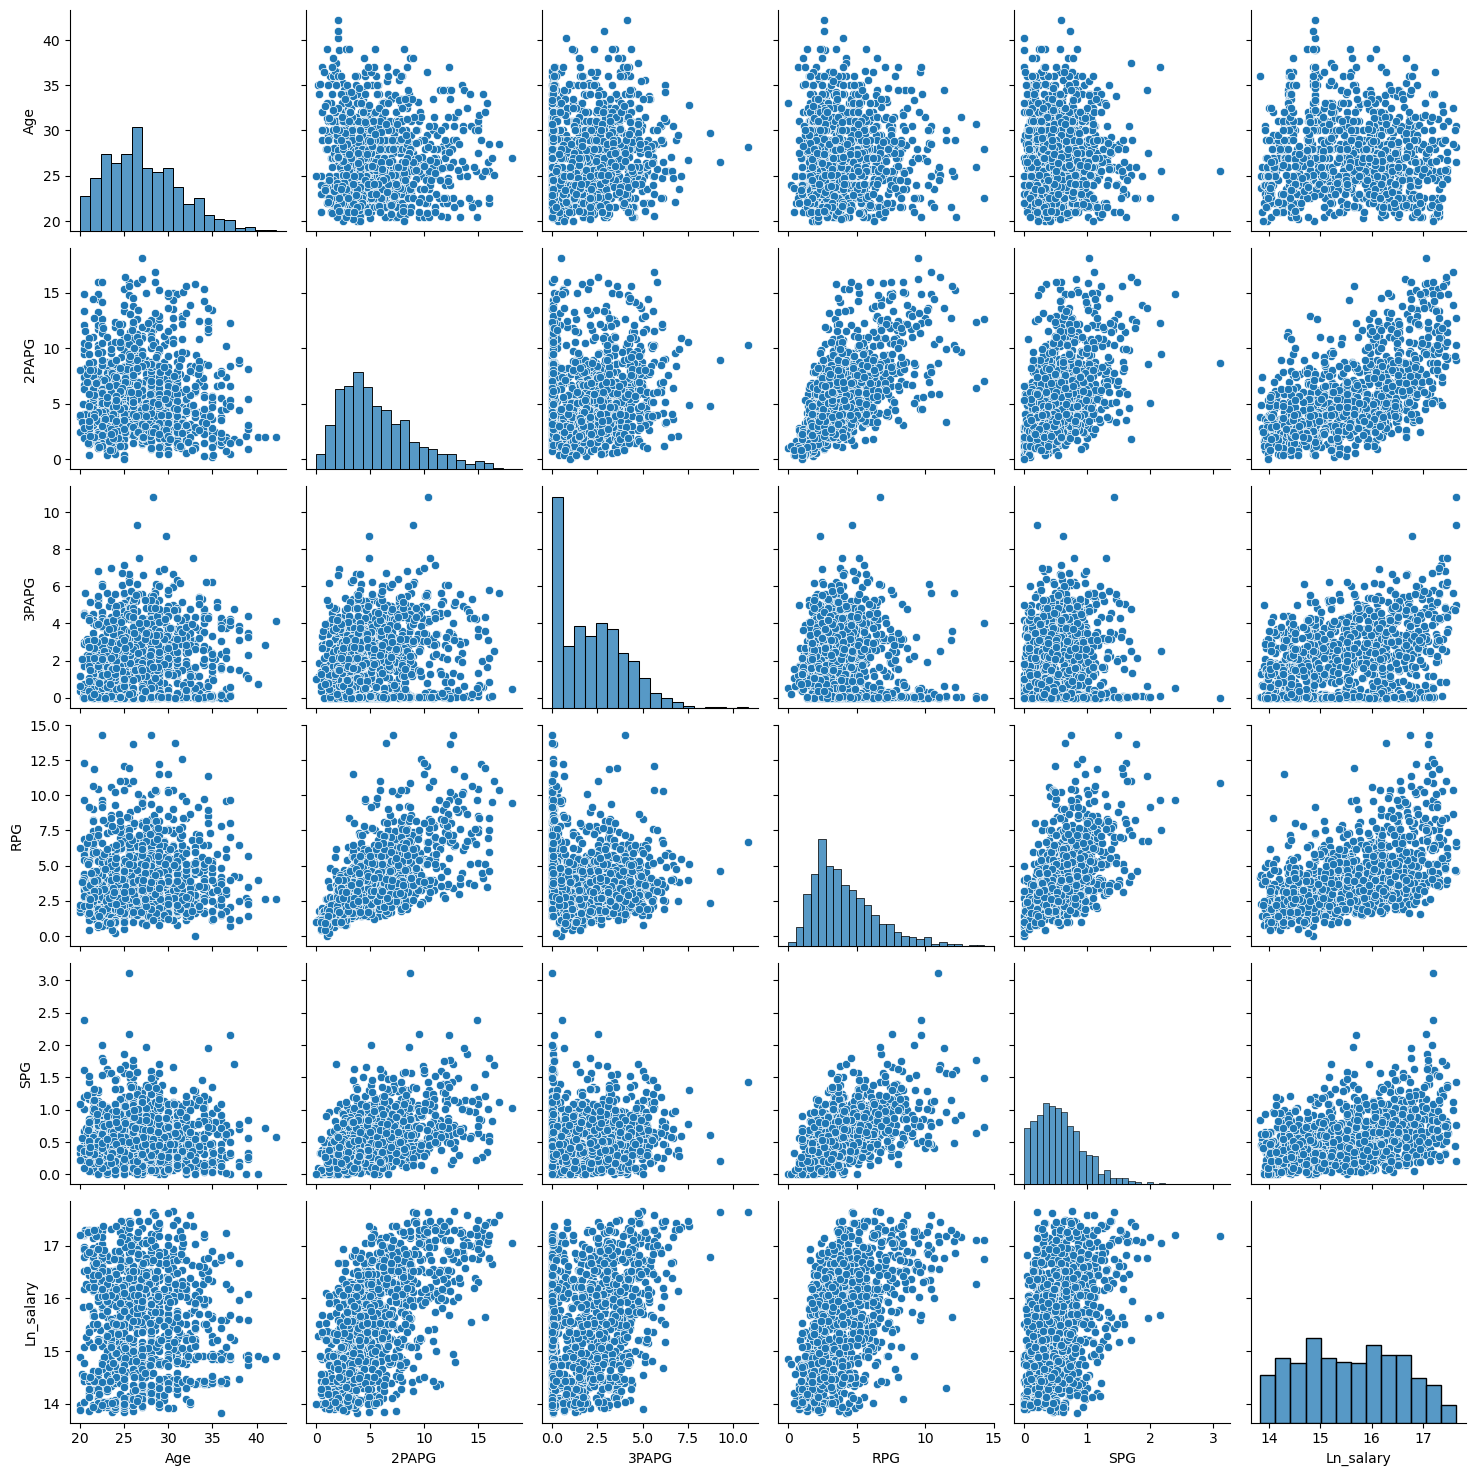

In [40]:
columns = ['Age', '2PAPG', '3PAPG', 'RPG', 'SPG', 'Ln_salary']
sns.pairplot(df3[columns])

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df3['SPG'] = scaler.fit_transform(df3[['SPG']])
df3['RPG'] = scaler.fit_transform(df3[['RPG']])
df3['2PAPG'] = scaler.fit_transform(df3[['2PAPG']])
df3['3PAPG'] = scaler.fit_transform(df3[['3PAPG']])

In [42]:
df3 = df3.astype ({"Recently_injured" : 'bool'})

## Korrelációs mátrix

In [43]:
selected_columns = ['Ln_salary','MPG', '2PAPG', '3PAPG','RPG','SPG','Sum_of_injuries','Age','Age^2']
corr_matrix = df3[selected_columns].corr()
corr_table = corr_matrix.style.set_properties(**{'font-family': 'Times New Roman', 'font-size': '12pt'}) \
                               .format("{:.2f}")
display(corr_table)

,Ln_salary,MPG,2PAPG,3PAPG,RPG,SPG,Sum_of_injuries,Age,Age^2
Ln_salary,1.00,0.67,0.60,0.28,0.52,0.40,0.15,-0.07,-0.08
MPG,0.67,1.00,0.78,0.47,0.55,0.46,0.20,0.04,0.03
2PAPG,0.60,0.78,1.00,0.09,0.63,0.46,0.18,-0.05,-0.06
3PAPG,0.28,0.47,0.09,1.00,-0.19,-0.03,0.15,0.08,0.07
RPG,0.52,0.55,0.63,-0.19,1.00,0.56,0.13,0.00,0.00
SPG,0.40,0.46,0.46,-0.03,0.56,1.00,0.05,-0.04,-0.04
Sum_of_injuries,0.15,0.20,0.18,0.15,0.13,0.05,1.00,0.41,0.39
Age,-0.07,0.04,-0.05,0.08,0.00,-0.04,0.41,1.00,1.00
Age^2,-0.08,0.03,-0.06,0.07,0.00,-0.04,0.39,1.00,1.00


## Gépi tanulás

In [44]:
X = df3[['2PAPG','3PAPG','RPG','SPG','Age']]
y = df3['Ln_salary']

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.3, random_state=101)

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.intercept_,np.exp(lm.intercept_))

16.08647851350773 9688774.579710457


In [49]:
X_train.columns

Index(['2PAPG', '3PAPG', 'RPG', 'SPG', 'Age'], dtype='object')

In [50]:
pd.options.display.float_format = '{:.2f}'.format

In [51]:
cdf = pd.DataFrame(lm.coef_,X.columns,columns = ['Coeff'])
cdf['e_coeff'] = np.exp(cdf['Coeff'])
print(cdf)

       Coeff  e_coeff
2PAPG   0.31     1.36
3PAPG   0.32     1.37
RPG     0.34     1.40
SPG     0.07     1.07
Age    -0.02     0.98


## Predikciók

In [52]:
predictions = lm.predict(X_test)

In [53]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,predictions))
print('MSE:', np.exp(metrics.mean_squared_error(y_test,predictions)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 0.583817251571633
MSE: 1.6581548424157297
RMSE: 0.7111296952283018


In [54]:
metrics.explained_variance_score(y_test,predictions)

0.4840678401517694

## Statsmodel csomaggal

## White teszt

In [55]:
X = df3.loc[:, ['2PAPG', '3PAPG', 'RPG', 'SPG', 'Age']]
y = df3.loc[:, 'Ln_salary']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

white_test = het_white(model.resid, X)

print("White Test Statistic:", white_test[0])
print("White Test p-value:", white_test[1])

White Test Statistic: 53.828740953098404
White Test p-value: 6.132807943351964e-05


## Robusztus standard hibákkal

In [56]:
X = df3.loc[:, ['2PAPG', '3PAPG', 'RPG', 'SPG', 'Age']]
y = df3.loc[:, 'Ln_salary']

X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
robust_cov = model.cov_HC3

pd.options.display.float_format = '{:.2f}'.format
print("Regressziós együtthatók:")
print(model.params,np.exp(model.params))

print("\nRészletes statisztikai információk (robust standard hibákkal):")
print(model.get_robustcov_results(cov_type='HC3').summary())

Regressziós együtthatók:
const   16.11
2PAPG    0.31
3PAPG    0.32
RPG      0.35
SPG      0.06
Age     -0.02
dtype: float64 const   9909669.95
2PAPG         1.36
3PAPG         1.38
RPG           1.41
SPG           1.07
Age           0.98
dtype: float64

Részletes statisztikai információk (robust standard hibákkal):
                            OLS Regression Results                            
Dep. Variable:              Ln_salary   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     225.0
Date:                Thu, 16 May 2024   Prob (F-statistic):          2.75e-163
Time:                        21:58:13   Log-Likelihood:                -1115.3
No. Observations:                1057   AIC:                             2243.
Df Residuals:                    1051   BIC:                             2272.
Df Model:                           5              